# Novel NMD targets?

Here we look for potentially novel NMD targets by identifying reads with frameshifts of annotated open reading frames

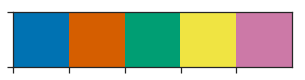

In [200]:
import sys
import os
from glob import glob
import random
from collections import defaultdict
import itertools as it

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam
from joblib import Parallel, delayed


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [160]:
%%bash
awk -v OFS='\t' '{print $1, $7, $8, $4, $5, $6}' /cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_protein_coding.201606.bed \
| sed -e 's/^Chr//' | sort -k1,1 -k2,2n > coding_regions.bed

In [158]:
%%bash
bedtools bamtobed -bed12 \
  -i /cluster/ggs_lab/mtparker/analysis_notebooks/chimeric_transcripts/vir1_vs_col0_ec/aligned_data/col0.merged.bam > \
nanopore_alns.bed

In [214]:
%%bash
bedtools intersect -sorted -wa -wb -F 1 -s \
  -a nanopore_alns.bed \
  -b coding_regions.bed |
awk -v OFS='\t' '{print $1, $2, $3, $16 "_" $4, $5, $6, $14, $15, $9, $10, $11, $12}' \
 > nanopore_alns_with_cds.bed

In [206]:
def is_fwd(aln):
    if aln.is_reverse:
        if aln.is_read1:
            return True
        else:
            return False
    else:
        if aln.is_read1:
            return False
        else:
            return True


def get_bam_introns(bam_fn):
    splices = defaultdict(set)
    with pysam.AlignmentFile(bam_fn) as bam:
        for chrom, strand in it.product(bam.references, ['+', '-']):
            if strand == '+':
                introns = bam.find_introns(
                    aln for aln in bam.fetch(chrom) if is_fwd(aln)
                )
            else:
                introns = bam.find_introns(
                    aln for aln in bam.fetch(chrom) if not is_fwd(aln)
                )
            for inv in introns:
                splices[(chrom, strand)].add(inv)
    return splices


def get_multibam_introns(bam_fns):
    n_proc = min(len(bam_fns), 12)
    introns = Parallel(n_jobs=n_proc)(
        delayed(get_bam_introns)(bam_fn) for bam_fn in bam_fns
    )
    all_introns = defaultdict(set)
    for i in introns:
        for contig, ci in i.items():
            all_introns[contig].update(ci)
    return all_introns

In [207]:
illumina_data = glob(
    '/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/vir_fpa_35SFPA_rnaseq/aligned_data/col0_*/Aligned.sorted.bam'
)

all_introns = get_multibam_introns(illumina_data)

In [269]:
def get_gtf_introns(gtf_fn):
    splices = defaultdict(set)
    with open(gtf_fn) as gtf:
        for record in gtf:
            record = record.split()
            chrom = re.sub('^Chr', '', record[0])
            chrom = re.sub('C', 'Pt', chrom)
            chrom = re.sub('M$', 'Mt', chrom)
            start = int(record[3]) - 1
            end = int(record[4])
            strand = record[6]
            splices[(chrom, strand)].add((start, end))
    return splices

In [270]:
annotated_introns = get_gtf_introns('/cluster/ggs_lab/mtparker/analysis_notebooks/splice_junc_counts/atrtd2_introns.gtf')

In [272]:
def parse_exons(record):
    start = int(record[1])
    exstarts = np.fromstring(record[11], sep=',', dtype=np.int) + start
    exlengths = np.fromstring(record[10], sep=',', dtype=np.int)
    exends = exstarts + exlengths
    return exstarts, exends


def get_cds(start, end, exstarts, exends):
    if len(exstarts) == 1:
        if not ((exstarts[0] <= start < exends[0]) & (exstarts[0] < end <= exends[0])):
            raise ValueError()
        else:
            return np.array([start]), np.array([end])
    inv_iter = zip(exstarts, exends)
    cds = []
    while True:
        ex_start, ex_end = next(inv_iter)
        if start > ex_end:
            continue
        elif ex_start <= start < ex_end:
            if end <= ex_end:
                return np.array([start]), np.array([end])
            else:
                cds.append([start, ex_end])
            break
        else:
            raise ValueError()

    while True:
        ex_start, ex_end = next(inv_iter)
        if ex_start < end <= ex_end:
            cds.append([ex_start, end])
            break
        elif end > ex_end:
            cds.append([ex_start, ex_end])
        else:
            raise ValueError()
    cds_starts, cds_ends = zip(*cds)
    cds_starts = np.array(cds_starts)
    cds_ends = np.array(cds_ends)
    return cds_starts, cds_ends


def alignment_introns_supported(exstarts, exends, chrom, strand, intron_set):
    exons = set()
    for s, e in zip(exstarts[1:], exends[:-1]):
        exons.add((e, s))
    return exons.issubset(intron_set[(chrom, strand)])


def find_frameshifts(bed12_fn, out_bed_fn):
    with open(bed12_fn) as bed, open(out_bed_fn, 'w') as obed:
        for line in bed:
            record = line.split()
            cds_start = int(record[6])
            cds_end = int(record[7])
            exstarts, exends = parse_exons(record)
            if alignment_introns_supported(exstarts, exends, record[0], record[5], all_introns):
                if not alignment_introns_supported(exstarts, exends, record[0], record[5], annotated_introns):
                    try:
                        cds_starts, cds_ends = get_cds(cds_start, cds_end, exstarts, exends)
                    except ValueError:
                        continue
                    cds_len = sum(cds_ends - cds_starts)
                    aa, f = divmod(cds_len, 3)
                    if f != 0:
                        obed.write(line)

In [273]:
find_frameshifts('nanopore_alns_with_cds.bed', 'nanopore_frameshifts.bed')

In [274]:
%%bash
wc -l nanopore_frameshifts.bed

8515 nanopore_frameshifts.bed
